# How Scapy Works
Scapy allows for packet creation and manipulation of network packets. It allows for packets to be crafted and sent. Under the hood it uses the `socket` library.
Scapy needs to be installed as root in order to have sufficient permissions.

Packets are crafted in a stack manner following the OSI model where each part of the packet it an object.
For example a packet can be crafted with the following:

In [305]:
import scapy.all as scapy
from scapy.all import *

# Packet where layer 2 is Ethernet, layer 3 is IP, and layer 4 is TCP.
packet = IP() / TCP() # An empty IP() defaults to our loopback address.
print(packet.summary())

IP / TCP 127.0.0.1:ftp_data > 127.0.0.1:http S


We can also add the Ethernet header to our packet. Like a stack, each portion is stacked on one another.

In [306]:
ether = Ether() / packet
print(ether.summary())

Ether / IP / TCP 127.0.0.1:ftp_data > 127.0.0.1:http S


Packets can be sent over the network using the `sr1() / sr()` function will send the packet and wait for the response. `srp1() / srp()` sends and recieves layer 2 packets.

In [307]:
r, u = srp(Ether() / IP(dst="8.8.8.8", ttl=(5, 10)) / UDP() / DNS())
print(r, u)

Begin emission
.
Finished sending 6 packets
*****
Received 7 packets, got 6 answers, remaining 0 packets
*<Results: TCP:0 UDP:3 ICMP:3 Other:0> <Unanswered: TCP:0 UDP:0 ICMP:0 Other:0>


We can also create a sessions using the `sniff` function. We can defragment IP packts using `IPSession` or certain TCP protocols using `TCPSession`.

In [308]:
# Creat an IPSession

session = IPSession()
sniff(session=IPSession, iface="eth0", count=10)

<Sniffed: TCP:3 UDP:5 ICMP:0 Other:2>

We can also have have the sniff command run a funtion on packets being recieved using the `prn` argument.

In [309]:
def packet_handler(packet):
    print(packet.summary())
    
sniff(iface="eth0", prn=packet_handler, count=10)

Ether / IP / TCP / TLS 52.182.143.210:443 > 172.31.72.58:48328 / TLS / Raw / TLS / TLS ChangeCipherSpec
Ether / IP / TCP 172.31.72.58:48328 > 52.182.143.210:https A
Ether / IP / TCP / TLS 172.31.72.58:48328 > 52.182.143.210:443 / TLS / TLS ChangeCipherSpec / TLS / TLS Handshake - Client Hello
Ether / IP / UDP / NTP v4, server
Ether / IP / UDP 172.31.64.1:53411 > 239.255.255.250:1900 / Raw
Ether / IP / TCP / TLS 52.182.143.210:443 > 172.31.72.58:48328 / TLS / TLS Handshake - Server Hello / Padding
Ether / IP / TCP 52.182.143.210:https > 172.31.72.58:48328 PA / _TLSEncryptedContent
Ether / IP / TCP 172.31.72.58:48328 > 52.182.143.210:https A
Ether / IP / TCP / TLS 172.31.72.58:48328 > 52.182.143.210:443 / TLS / TLS Application Data / Padding
Ether / IP / TCP 172.31.72.58:48328 > 52.182.143.210:https PA / _TLSEncryptedContent


<Sniffed: TCP:8 UDP:2 ICMP:0 Other:0>

We can also visualize our data using the `multiplot` function.

[[<matplotlib.lines.Line2D at 0x7f8726fc7550>],

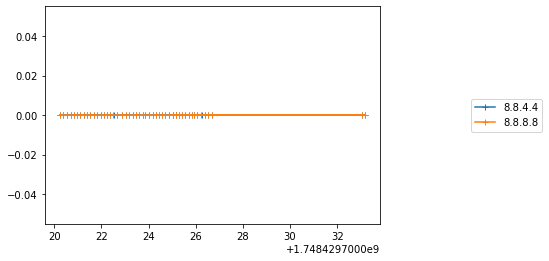

In [310]:
ans, unans = srloop(IP(dst=["8.8.8.8", "8.8.4.4"])/ICMP(), inter=.1, timeout=.1, count=50, verbose=False)
%matplotlib inline
ans.multiplot(lambda x, y: (y[IP].src, (y.time, y[IP].id)), plot_xy=True)

We can also run a traceroute using the `traceroute` command.

In [311]:
ans, unans = traceroute('www.google.com', maxttl=15)
print(ans, unans)

Begin emission
**
Finished sending 15 packets
**********
Received 12 packets, got 12 answers, remaining 3 packets
   142.250.204.4:tcp80 
1  172.31.64.1     11  
2  192.168.1.1     11  
6  192.178.97.217  11  
7  142.251.64.177  11  
8  142.250.204.4   SA  
9  142.250.204.4   SA  
10 142.250.204.4   SA  
11 142.250.204.4   SA  
12 142.250.204.4   SA  
13 142.250.204.4   SA  
14 142.250.204.4   SA  
15 142.250.204.4   SA  
<Traceroute: TCP:8 UDP:0 ICMP:4 Other:0> <Unanswered: TCP:3 UDP:0 ICMP:0 Other:0>


## Creating Custom Protocols Using Scapy

We can use python's socket library in conjunction with scapy using `StreamSocket`

In [312]:
import socket
from scapy.layers.dns import DNS

sck = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sck.connect(("8.8.8.8", 53))

ssck = StreamSocket(sck, DNS) # (Socket, Base Protocol Class)

# Send the DNS query
packet = ssck.sr1(DNS(rd=1, qd=DNSQR(qname="www.google.com")))
print(packet.show())

sck.close()

Begin emission

Finished sending 1 packets
*
Received 1 packets, got 1 answers, remaining 0 packets
###[ DNS ]###
  id        = 0
  qr        = 1
  opcode    = QUERY
  aa        = 0
  tc        = 0
  rd        = 1
  ra        = 1
  z         = 0
  ad        = 0
  cd        = 0
  rcode     = ok
  qdcount   = 1
  ancount   = 1
  nscount   = 0
  arcount   = 0
  \qd        \
   |###[ DNS Question Record ]###
   |  qname     = b'www.google.com.'
   |  qtype     = A
   |  unicastresponse= 0
   |  qclass    = IN
  \an        \
   |###[ DNS Resource Record ]###
   |  rrname    = b'www.google.com.'
   |  type      = A
   |  cacheflush= 0
   |  rclass    = IN
   |  ttl       = 174
   |  rdlen     = None
   |  rdata     = 142.250.204.4
  \ns        \
  \ar        \

None


We can define our own stream socket packet base class alowing implementation of our own protocols.

In [313]:
class DNSTCP(Packet):
    name = "DNS over TCP"
    
    fields_desc = [ FieldLenField("len", None, fmt="!H", length_of="dns"),
                    PacketLenField("dns", 0, DNS, length_from=lambda p: p.len)]
    
    # This method tells Scapy that the next packet must be decoded with DNSTCP
    def guess_payload_class(self, payload):
        return DNSTCP
    
# Build then decode a DNS message over TCP
DNSTCP(raw(DNSTCP(dns=DNS())))

<DNSTCP  len=33 dns=<DNS  id=0 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=[<DNSQR  qname=b'www.example.com.' qtype=A unicastresponse=0 qclass=IN |>] |> |>

In [314]:
import socket

sck = socket.socket(socket.AF_INET, socket.SOCK_STREAM)  # create an TCP socket
sck.connect(("8.8.8.8", 53))  # connect to 8.8.8.8 on 53/TCP

# Create the StreamSocket and gives the class used to decode the answer
ssck = StreamSocket(sck, DNSTCP)

# Send the DNS query
packet = ssck.sr1(DNSTCP(dns=DNS(rd=1, qd=DNSQR(qname="www.google.com"))))
print(packet.show())

Begin emission

Finished sending 1 packets
*
Received 1 packets, got 1 answers, remaining 0 packets
###[ DNS over TCP ]###
  len       = 48
  \dns       \
   |###[ DNS ]###
   |  id        = 0
   |  qr        = 1
   |  opcode    = QUERY
   |  aa        = 0
   |  tc        = 0
   |  rd        = 1
   |  ra        = 1
   |  z         = 0
   |  ad        = 0
   |  cd        = 0
   |  rcode     = ok
   |  qdcount   = 1
   |  ancount   = 1
   |  nscount   = 0
   |  arcount   = 0
   |  \qd        \
   |   |###[ DNS Question Record ]###
   |   |  qname     = b'www.google.com.'
   |   |  qtype     = A
   |   |  unicastresponse= 0
   |   |  qclass    = IN
   |  \an        \
   |   |###[ DNS Resource Record ]###
   |   |  rrname    = b'www.google.com.'
   |   |  type      = A
   |   |  cacheflush= 0
   |   |  rclass    = IN
   |   |  ttl       = 170
   |   |  rdlen     = None
   |   |  rdata     = 142.250.204.4
   |  \ns        \
   |  \ar        \

None
